In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
from scipy.stats import sem
import matplotlib.ticker as mtick
from scipy import interpolate
from scipy.interpolate import griddata
from matplotlib import ticker, cm
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from scipy.stats import norm
import matplotlib.mlab as mlab
# from stl import mesh
import math
import random
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

In [101]:
os.getcwd()

NameError: name 'os' is not defined

## Below : noise surface generator

wc is the variable associated with the cutoff frequency

C:\Users\jlmph\anaconda3\lib\site-packages\numpy\ma\core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


0.5
[[ 0.03224275-2.24249962e-16j  0.75053661-2.94037001e-16j
   1.49184189-2.26719675e-16j ... -1.5280434 -1.64208414e-16j
  -1.14604973-7.74109212e-16j -0.61436107-5.44639593e-16j]
 [ 0.41504558-2.45842312e-16j  1.11173719-1.21298201e-16j
   1.82301344-7.55732249e-17j ... -1.13914331-3.26151039e-16j
  -0.7488222 -6.33758937e-16j -0.21931208-3.61104618e-16j]
 [ 0.75002772-2.67434662e-16j  1.40516886-4.57249764e-17j
   2.06582898-1.40350275e-16j ... -0.75049976-2.39781639e-16j
  -0.36494007-5.79778062e-16j  0.14632218-4.79862543e-16j]
 ...
 [-1.22146261-3.39408655e-16j -0.56052424-1.92194550e-16j
   0.14137007-3.20325033e-16j ... -2.5303605 +1.29403100e-17j
  -2.24269813-7.64913254e-16j -1.79566598-3.95422389e-16j]
 [-0.80537517-4.24508430e-16j -0.10574257-3.22146839e-16j
   0.63037472-8.99386258e-17j ... -2.23906067-3.30746673e-16j
  -1.90996323-6.71327689e-16j -1.42083906-7.40247235e-16j]
 [-0.3809416 -4.58390563e-16j  0.33824008-4.63845891e-16j
   1.08784121-4.76169293e-16j ... -1.9

'\nChange these below and uncomment to save appropriate surface\n'

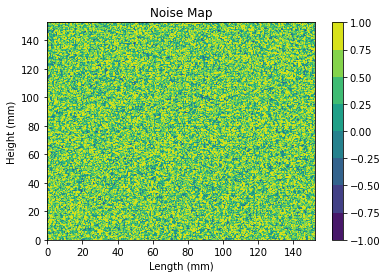

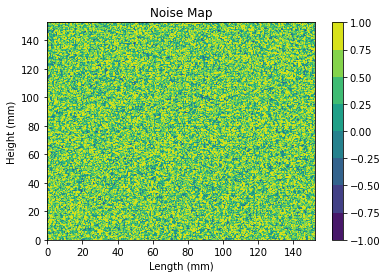

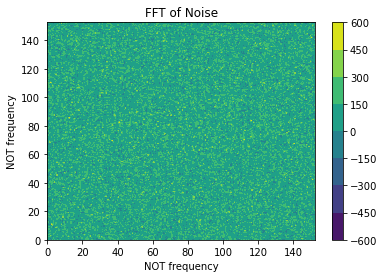

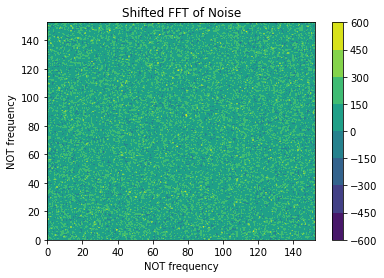

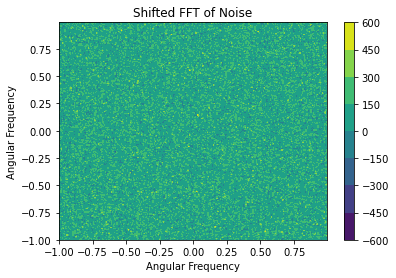

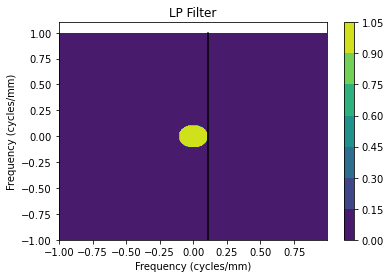

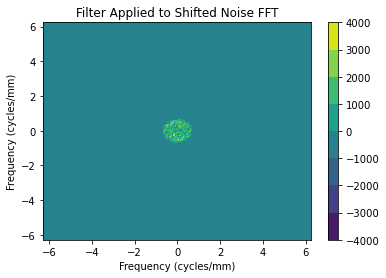

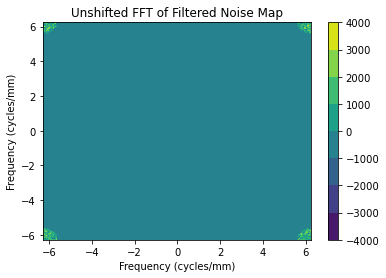

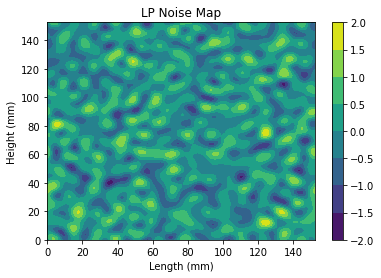

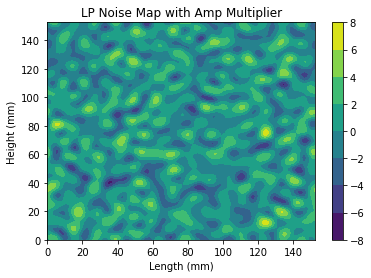

In [2]:
### INITIALIZE ###
L = 153 #length of side of sample - mm - 81mm
H = 153 # mm - should be something like 42mm
Nl = L * 2 #would L*2 be the Nyquist?
Nh = H * 2
dL = L/Nl #space between sample points
dH = H/Nh #these are equal - as they should be (?)
#print(dL,dH)
f = 100 #Hz or cycles/mm 75 works well for visualization
wc = f / (2*np.pi) #rad/sec or rad/mm
amp = 1 #amplitude +/- of noise
desired_featuresize = 5 #mm across
safety_mult = 2.8 #Extra multiplier term to even further increase % of 45deg facets


x = np.arange(0,L,dL)
y = np.arange(0,H,dH)
X,Y = np.meshgrid(x,y)

### ESTABLISH NOISE MAP ###
wn2d = np.random.uniform(-amp,amp,(Nh,Nl))
plt.figure()
plt.contourf(X,Y,wn2d)
plt.colorbar()
plt.title("Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### MAKE A PLANE WAVE ###

#wn2d = amp * np.sin(0.15 * Y) #########################
plt.figure()
plt.contourf(X,Y,wn2d)
plt.colorbar()
plt.title("Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### TAKE 2D FFT ###
wn2d_fft = np.fft.fft2(wn2d)
plt.figure()
plt.contourf(X,Y,wn2d_fft)
plt.colorbar()
plt.title("FFT of Noise")
plt.xlabel("NOT frequency")
plt.ylabel("NOT frequency")

### SHIFT THE FFT TO 0 ###
wn2d_shift = np.fft.fftshift(wn2d_fft)
plt.figure()
plt.contourf(X,Y,wn2d_shift)
plt.colorbar()
plt.title("Shifted FFT of Noise")
plt.xlabel("NOT frequency")
plt.ylabel("NOT frequency")

### CONVERT TO FERQUENCY AXIS DOMAIN ### I SUSPECT HERE IS WHERE THE ASYMMETRY HAPPENS
#freq bins - THESE NEED CHECKED
print(dL)
#freqs = np.fft.fftfreq((len(x),len(y)))
freqx = np.fft.fftshift(np.fft.fftfreq(x.shape[0],dL))
freqy = np.fft.fftshift(np.fft.fftfreq(y.shape[0],dH))
fX,fY = np.meshgrid(freqx, freqy)
#print(freqx)
#print(freqy)
plt.figure()
plt.contourf(fX,fY,wn2d_shift)
plt.colorbar()
plt.title("Shifted FFT of Noise")
plt.xlabel("Angular Frequency")
plt.ylabel("Angular Frequency")

### MAKE THE LP FILTER ###
#make lp filter
rows, cols = wn2d.shape
crow, ccol = int(rows/2), int(cols/2)
#lpf = np.zeros((rows, cols, 2))
lpf = np.zeros((rows, cols))
center = [crow, ccol]
xlpf, ylpf = np.ogrid[:rows, :cols]
lpf_area = (xlpf - center[0])**2 + (ylpf - center[1])**2 <= wc**2
lpf[lpf_area] = 1
#lpf = np.ones((Nl,Nh)) ############################ THIS CAN BE UNCOMMENTED TO STOP FILTER
#print(lpf)
plt.figure()
plt.contourf(freqx,freqy,lpf) #scaled from angular freq to Hz
plt.plot([0.111, 0.111], [-1, 1], '-k')
plt.colorbar()
plt.title("LP Filter")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### APPLY THE FILTER TO THE SHIFTED FFT ###
fftwn2d_lp = lpf*wn2d_shift * 10 ###THIS MULTIPLIER HERE WILL CHANGE THE DERIV CALC
plt.figure()
plt.contourf(2*np.pi*fX, 2*np.pi*fY, fftwn2d_lp)
plt.colorbar()
plt.title("Filter Applied to Shifted Noise FFT")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### UNSHIFT THE FILTERED FFT ###
fftwn2d_lp_unshift = np.fft.ifftshift(fftwn2d_lp)
plt.figure()
plt.contourf(2*np.pi*fX, 2*np.pi*fY, fftwn2d_lp_unshift)
plt.colorbar()
plt.title("Unshifted FFT of Filtered Noise Map")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### TAKE THE INVERSE FFT TO GET A FILTERED SIGNAL BACK ###
wn2d_lp = np.fft.ifft2(fftwn2d_lp_unshift)
plt.figure()
plt.contourf(X,Y,wn2d_lp)
plt.colorbar()
plt.title("LP Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### AMPLIFYING FEATURE SIZES TO INCREASE DERIVATIVES ###
#for significant % of 45deg derivatives
scale = desired_featuresize / 2
map_max = np.amax(np.abs(wn2d_lp))
multiplier = scale / map_max
wn2d_lp = wn2d_lp * multiplier * safety_mult
plt.figure()
plt.contourf(X,Y,wn2d_lp)
plt.colorbar()
plt.title("LP Noise Map with Amp Multiplier")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")



print(wn2d_lp)
'''
Change these below and uncomment to save appropriate surface
'''
#np.save('Random_Maps/wn2d_L42_W42_fc75_A1.npy', wn2d_lp)

#wn2d_lp_real = wn2d_lp.real
#wn2d_lp_real = ['{:f}'.format(item) for item in wn2d_lp_real]

#np.savetxt('lptest.txt', wn2d_lp.real, delimiter=',', fmt='%f')


## Same as above but using plane wave input

check for physical frequency cutoff by seeing when the plane wave gets cut to nothing

0.5
[[7.        +2.60176130e-16j 6.95223066+4.73169308e-16j
  5.96946282+5.98634142e-16j ... 2.22789088+1.61087938e-16j
  4.4182    -1.90294497e-16j 6.1044825 +3.25648535e-16j]
 [7.        +2.60359694e-16j 6.95223066+4.73241678e-16j
  5.96946282+5.98588353e-16j ... 2.22789088+1.61432052e-16j
  4.4182    -1.89965308e-16j 6.1044825 +3.25921762e-16j]
 [7.        +2.60885594e-16j 6.95223066+4.73449015e-16j
  5.96946282+5.98457170e-16j ... 2.22789088+1.62417918e-16j
  4.4182    -1.89022199e-16j 6.1044825 +3.26704543e-16j]
 ...
 [7.        +2.61682806e-16j 6.95223066+4.73763316e-16j
  5.96946282+5.98258311e-16j ... 2.22789088+1.63912390e-16j
  4.4182    -1.87592542e-16j 6.1044825 +3.27891157e-16j]
 [7.        +2.60885594e-16j 6.95223066+4.73449015e-16j
  5.96946282+5.98457170e-16j ... 2.22789088+1.62417918e-16j
  4.4182    -1.89022199e-16j 6.1044825 +3.26704543e-16j]
 [7.        +2.60359694e-16j 6.95223066+4.73241678e-16j
  5.96946282+5.98588353e-16j ... 2.22789088+1.61432052e-16j
  4.4182  

'\nChange these below and uncomment to save appropriate surface\n'

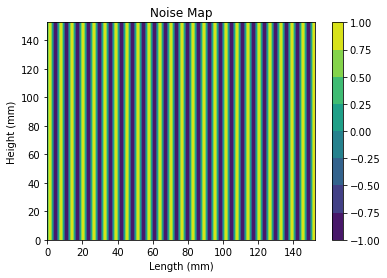

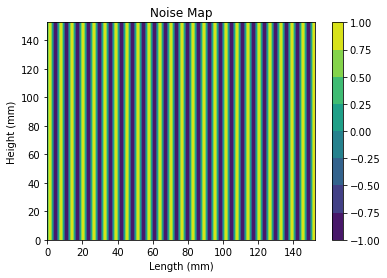

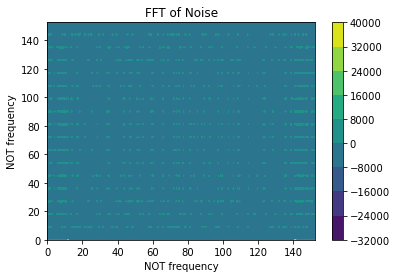

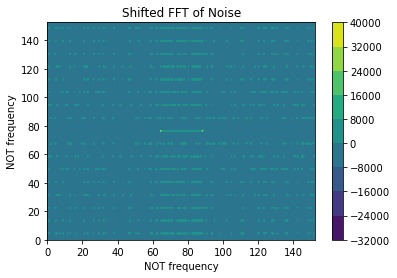

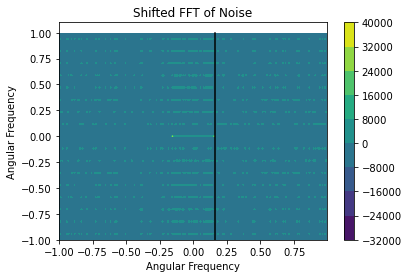

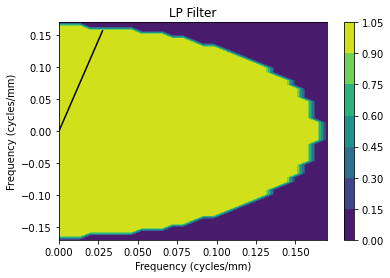

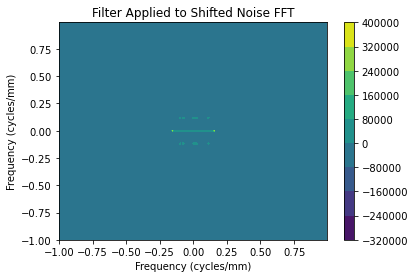

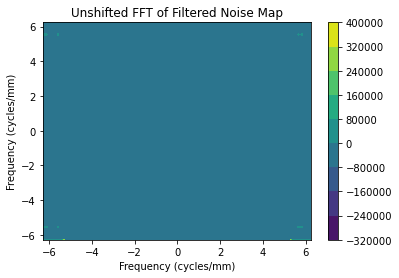

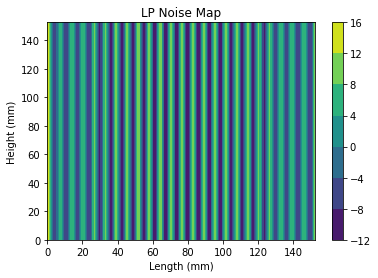

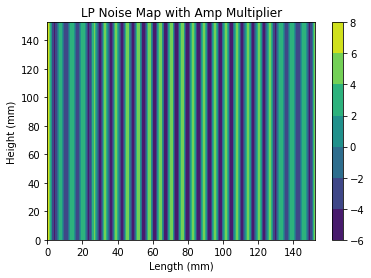

In [100]:
### INITIALIZE ###
L = 153 #length of side of sample - mm - 81mm
H = 153 # mm - should be something like 42mm
Nl = L * 2 #would L*2 be the Nyquist?
Nh = H * 2
dL = L/Nl #space between sample points
dH = H/Nh #these are equal - as they should be (?)
#print(dL,dH)
f = 100 #Hz or cycles/mm 75 works well for visualization
#wc = f / (2*np.pi) #rad/sec or rad/mm
wc = 2*np.pi * 4 # need this factor of 4 for some reason in the filter
amp = 1 #amplitude +/- of noise
desired_featuresize = 5 #mm across
safety_mult = 2.8 #Extra multiplier term to even further increase % of 45deg facets


x = np.arange(0,L,dL)
y = np.arange(0,H,dH)
X,Y = np.meshgrid(x,y)

### ESTABLISH NOISE MAP ###
wn2d = np.random.uniform(-amp,amp,(Nh,Nl))
wn2d = np.ones((Nl,Nh)) * np.sin(np.linspace(0,L,Nl))
plt.figure()
plt.contourf(X,Y,wn2d)
plt.colorbar()
plt.title("Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### MAKE A PLANE WAVE ###

#wn2d = amp * np.sin(0.15 * Y) #########################
plt.figure()
plt.contourf(X,Y,wn2d)
plt.colorbar()
plt.title("Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### TAKE 2D FFT ###
wn2d_fft = np.fft.fft2(wn2d)
plt.figure()
plt.contourf(X,Y,wn2d_fft)
plt.colorbar()
plt.title("FFT of Noise")
plt.xlabel("NOT frequency")
plt.ylabel("NOT frequency")

### SHIFT THE FFT TO 0 ###
wn2d_shift = np.fft.fftshift(wn2d_fft)
plt.figure()
plt.contourf(X,Y,wn2d_shift)
plt.colorbar()
plt.title("Shifted FFT of Noise")
plt.xlabel("NOT frequency")
plt.ylabel("NOT frequency")

### CONVERT TO FERQUENCY AXIS DOMAIN ### I SUSPECT HERE IS WHERE THE ASYMMETRY HAPPENS
#freq bins - THESE NEED CHECKED
print(dL)
#freqs = np.fft.fftfreq((len(x),len(y)))
freqx = np.fft.fftshift(np.fft.fftfreq(x.shape[0],dL))
freqy = np.fft.fftshift(np.fft.fftfreq(y.shape[0],dH))

fX,fY = np.meshgrid(freqx, freqy)
#print(freqx)
#print(freqy)
plt.figure()
plt.contourf(fX,fY,wn2d_shift) 
plt.plot([1/(2*np.pi), 1/(2*np.pi)], [-1, 1], '-k')

plt.colorbar()
plt.title("Shifted FFT of Noise")
plt.xlabel("Angular Frequency")
plt.ylabel("Angular Frequency")

### MAKE THE LP FILTER ###
#make lp filter
rows, cols = wn2d.shape
crow, ccol = int(rows/2), int(cols/2)
#lpf = np.zeros((rows, cols, 2))
lpf = np.zeros((rows, cols))
center = [crow, ccol]
xlpf, ylpf = np.ogrid[:rows, :cols]
lpf_area = (xlpf - center[0])**2 + (ylpf - center[1])**2 <= wc**2
lpf[lpf_area] = 1
# lpf = np.ones((Nl,Nh)) ############################ THIS CAN BE UNCOMMENTED TO STOP FILTER
#print(lpf)
plt.figure()
plt.contourf(freqx,freqy,lpf) #scaled from angular freq to Hz
# plt.plot([0.111, 0.111], [-1, 1], '-k')

# plt.plot([(1/(2*np.pi)), (1/(2*np.pi))], [-1, 1], '-k')

plt.colorbar()
plt.title("LP Filter")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")
plt.xlim(0.00,0.17)
plt.ylim(-0.17,0.17)
'''
THIS ONLY PLOTS HALF OF THE FILTER - COMMENT OUT THE XLIM AND YLIM LINES ABOVE TO SEE FULL FILTER
'''
plt.plot([0.0, (1/(2*np.pi))*np.sin(np.deg2rad(10))], [0.0, (1/(2*np.pi))*np.cos(np.deg2rad(10))], '-k') #PLOTS THE RADIAL LINE IN THE FILTER

### APPLY THE FILTER TO THE SHIFTED FFT ###
fftwn2d_lp = lpf*wn2d_shift * 10 ###THIS MULTIPLIER HERE WILL CHANGE THE DERIV CALC
plt.figure()
plt.contourf(fX, fY, fftwn2d_lp)
plt.colorbar()
plt.title("Filter Applied to Shifted Noise FFT")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### UNSHIFT THE FILTERED FFT ###
fftwn2d_lp_unshift = np.fft.ifftshift(fftwn2d_lp)
plt.figure()
plt.contourf(2*np.pi*fX, 2*np.pi*fY, fftwn2d_lp_unshift)
plt.colorbar()
plt.title("Unshifted FFT of Filtered Noise Map")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### TAKE THE INVERSE FFT TO GET A FILTERED SIGNAL BACK ###
wn2d_lp = np.fft.ifft2(fftwn2d_lp_unshift)
plt.figure()
plt.contourf(X,Y,wn2d_lp)
plt.colorbar()
plt.title("LP Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### AMPLIFYING FEATURE SIZES TO INCREASE DERIVATIVES ###
#for significant % of 45deg derivatives
scale = desired_featuresize / 2
map_max = np.amax(np.abs(wn2d_lp))
multiplier = scale / map_max
wn2d_lp = wn2d_lp * multiplier * safety_mult
plt.figure()
plt.contourf(X,Y,wn2d_lp)
plt.colorbar()
plt.title("LP Noise Map with Amp Multiplier")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")



print(wn2d_lp)
'''
Change these below and uncomment to save appropriate surface
'''
#np.save('Random_Maps/wn2d_L42_W42_fc75_A1.npy', wn2d_lp)

#wn2d_lp_real = wn2d_lp.real
#wn2d_lp_real = ['{:f}'.format(item) for item in wn2d_lp_real]

#np.savetxt('lptest.txt', wn2d_lp.real, delimiter=',', fmt='%f')
